In [28]:
from train_lfp import *
from lfp_error_analysis import *

In [2]:
import tensorflow.keras.models as models

In [29]:
# load data
data = pd.read_csv("data/lfp.csv")

In [4]:
times = [i for i in range(-299, 301)]

In [5]:
num_directions = 12
num_dimensions = 16
encoded_eye_direc = True
align_starting_timestep = True
if encoded_eye_direc:
    data = pd.concat([data, pd.get_dummies(data.eye_direction)], axis=1)
trials, keymapping = create_trials_mapping(data, num_directions)
num_trials = len(keymapping)
train_inds, test_inds, val_inds = create_train_test_val_inds(num_trials)
trials, means, stds = normalize(trials, train_inds, keymapping,
                                    num_directions, encoded_eye_direc)


## Error Analysis

In [6]:
# load error files
avg_errors = np.load('lfp_errors/avg_errors.npy')
errors_by_channel = np.load('lfp_errors/errors_by_channel.npy')
errors_by_direction = np.load('lfp_errors/errors_by_direction.npy')
errors_by_time = np.load('lfp_errors/errors_by_time.npy', allow_pickle = True)
full_errors = np.load('lfp_errors/full_errors.npy')
errors_by_direction_time = dict()
errors_by_channel_time = dict()
lags = [1, 5, 10, 25, 50, 100]
timesteps = [150, 100, 50, 20, 10, 5]
for timestep in timesteps:
    for lag in lags:
        timestep_lag = str(timestep) + "_" + str(lag)
        errors_by_direction_time[(timestep, lag)] = np.load('lfp_errors/errors_by_direction_time' +
                                                            timestep_lag + '.npy')
        errors_by_channel_time[(timestep, lag)] = np.load('lfp_errors/errors_by_channel_time' +
                                                         timestep_lag + '.npy')
        

In [7]:
import matplotlib.pyplot as plt

In [ ]:
# calculates errors for base models - don't change
from sklearn import metrics
timestep = 150 
pad = 0
mses_avg = []
mses_prev = []
for lag in lags:
    trial_sequences, trial_targets, X_train, y_train, X_test, y_test, X_val, y_val = \
    create_sequences_train_test_val(trials, timestep, train_inds, test_inds, val_inds, keymapping, num_directions)
    mses_avg.append(metrics.mean_squared_error(y_test, np.zeros(y_test.shape)))
    y_pred = X_test[:,timestep-1,:num_dimensions]
    mses_prev.append(metrics.mean_squared_error(y_test, y_pred))

In [30]:
avg_errors =  np.vstack((avg_errors, np.array(mses_avg), np.array(mses_prev)))

In [31]:
df = pd.DataFrame(avg_errors)
df = df.rename(index = lambda x: timesteps[x] if x < 6 else x)

In [32]:
# MSE by timesteps and lag - timesteps is left axis
df = df.rename(index = lambda x: 'average' if x == 6 else x)
df = df.rename(index = lambda x: 'previous' if x == 7 else x)
df.rename(columns = lambda x: lags[x])

,1,5,10,25,50,100
150,0.002630,0.222366,0.481537,0.730148,0.835936,0.902107
100,0.001175,0.227358,0.487709,0.748654,0.847792,0.905690
50,0.000688,0.226651,0.471629,0.763586,0.893344,0.943871
20,0.000808,0.226641,0.478178,0.775349,0.905821,0.944212
10,0.001886,0.239946,0.508851,0.802302,0.946334,0.994078
5,0.012501,0.267104,0.531090,0.839109,0.950142,0.992679
average,0.998855,1.001973,1.005574,1.015914,1.035973,1.041634
previous,0.055871,0.383875,0.742463,1.235733,1.621894,1.952795


In [8]:
# MSE by lag and channel based on selected timestep
timestep_index = 0
df = pd.DataFrame(errors_by_channel[timestep_index])
df.rename(index = lambda x: lags[x])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1,0.002279,0.002049,0.002336,0.002723,0.001887,0.002729,0.002709,0.002693,0.002321,0.002872,0.002830,0.003352,0.002510,0.001895,0.003775,0.003117
5,0.186022,0.178443,0.159969,0.276323,0.172754,0.267060,0.264112,0.238938,0.186322,0.247430,0.238913,0.239430,0.222540,0.195947,0.229416,0.254237
10,0.425919,0.473910,0.422568,0.529367,0.455709,0.534006,0.530807,0.513143,0.434289,0.508186,0.477536,0.473280,0.473641,0.495662,0.473619,0.482957
25,0.658527,0.756062,0.685914,0.754488,0.732459,0.766561,0.761095,0.770812,0.684135,0.734786,0.706728,0.719433,0.734744,0.807996,0.693970,0.714658
50,0.802334,0.842419,0.813849,0.852767,0.845107,0.849273,0.844076,0.877499,0.772866,0.824664,0.816628,0.808028,0.849067,0.960434,0.797478,0.818485
100,0.891769,0.910373,0.883558,0.918281,0.908579,0.923221,0.899077,0.954179,0.858532,0.885198,0.878570,0.894351,0.928847,1.011108,0.828646,0.859415


In [9]:
# MSE by lag and saccade direction
timestep_index = 0
df = pd.DataFrame(errors_by_direction[timestep_index])
df.rename(index = lambda x: lags[x])

,0,1,2,3,4,5,6,7,8,9,10,11
1,0.002526,0.002516,0.002856,0.002760,0.002631,0.002566,0.002490,0.002566,0.002586,0.002828,0.002908,0.002651
5,0.218173,0.225668,0.234960,0.220177,0.217131,0.217118,0.212862,0.219518,0.222339,0.234300,0.236085,0.222237
10,0.470220,0.447433,0.531453,0.506139,0.444074,0.458478,0.462459,0.472874,0.486044,0.523068,0.539632,0.501592
25,0.766531,0.672194,0.890727,0.810724,0.638479,0.690185,0.742277,0.756748,0.707835,0.722779,0.709122,0.695281
50,0.807202,0.713797,0.960557,0.965885,0.697017,0.801988,0.855853,0.902723,0.853253,0.961513,0.826475,0.774027
100,0.894263,0.703129,0.853049,0.872266,0.763814,0.878324,0.995411,0.918973,1.020538,1.165410,1.025430,0.839399


In [10]:
# MSE by channel and direction, based on selected lag and timestep index
lag_index = 5
timestep_index = 0
df = pd.DataFrame(full_errors[timestep_index][lag_index])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.785115,0.979866,0.882605,0.936183,0.973862,0.894486,0.935329,1.172318,0.850464,0.798446,0.838495,0.814787,0.785850,1.016312,0.912831,0.731258
1,0.792910,0.682005,0.658601,0.738637,0.773984,0.813865,0.714206,0.772852,0.570408,0.602484,0.652408,0.603020,0.612351,0.936829,0.645689,0.679817
2,0.741155,0.724624,0.755849,0.771878,0.697738,0.820395,0.735950,0.772106,0.921961,0.980692,0.822615,0.861742,0.891766,1.001656,1.045814,1.102848
3,1.079084,1.110207,1.207728,0.813874,1.175474,0.853001,1.044893,0.949662,0.776883,0.804980,0.776055,0.739434,0.657000,0.635982,0.644174,0.687823
4,0.678074,0.709312,0.769472,0.792335,0.761932,0.690733,0.783067,0.813667,0.624694,0.725873,0.785620,0.987629,1.011541,0.632935,0.624772,0.829370
5,0.760654,0.796984,0.740779,1.019952,0.726107,0.915768,0.838549,0.890611,0.861013,0.977414,0.917021,1.012509,1.162469,0.907125,0.716442,0.809790
6,0.922538,1.061456,0.894808,1.054742,1.033138,1.079801,1.034001,1.102768,0.973606,0.951457,0.984993,0.891794,1.067827,1.221875,0.841019,0.810745
7,0.779646,0.865696,0.816424,0.978684,0.917318,0.935816,1.005138,1.141747,0.844320,0.895507,0.916931,0.887624,0.931831,1.174261,0.751664,0.860957
8,1.171444,0.967906,0.902901,0.945073,0.911645,1.024217,0.895510,0.908141,1.013439,1.121017,1.011191,0.981743,1.048885,1.227806,1.163663,1.034022
9,1.295995,1.255130,1.256597,1.267424,1.299014,1.177076,1.066353,1.062031,1.178526,1.145780,1.170771,1.242248,1.145618,1.124995,0.957852,1.001154


## Plot MSE by timestep and lag, include two base models

IndexError: index 6 is out of bounds for axis 0 with size 6

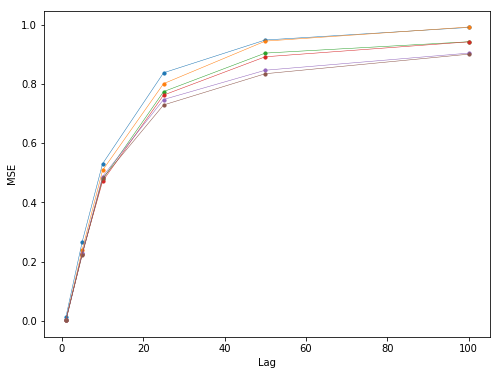

In [11]:

plt.figure(figsize = (8, 6))
for i in reversed(range(len(timesteps))):
    plt.scatter(lags, avg_errors[i], label = 'timesteps = ' + str(timesteps[i]), s = 10)
    plt.plot(lags, avg_errors[i], linewidth = .5)
    plt.ylabel("MSE")
    plt.xlabel("Lag")
plt.scatter(lags, avg_errors[6], label = 'average', s = 10)
plt.plot(lags, avg_errors[6])
plt.scatter(lags, avg_errors[7], label = 'previous', s = 10)
plt.plot(lags, avg_errors[7])
plt.legend()
plt.savefig("MSE_By_Timesteps")
plt.show()

## Plot MSE by time point in trial

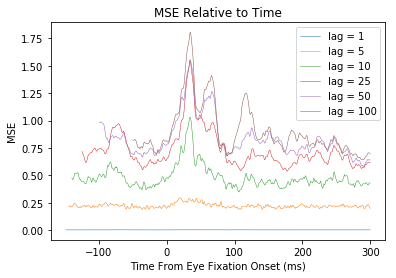

In [12]:
import matplotlib.pyplot as plt
times = [i for i in range(-299, 301)]
timestep_index = 0
for i in range(len(lags)):
    lag = lags[i]
    sequence_length = errors_by_time[0][i].shape[0]
    ticks = times[600 - sequence_length:]
    start =  0
    end = len(ticks)
    plt.plot(ticks[start:end], errors_by_time[timestep_index][i], linewidth = .5, label = 'lag = ' + str(lag))
    plt.ylabel('MSE')
    plt.xlabel('Time From Eye Fixation Onset (ms)')
    plt.title('MSE Relative to Time')
plt.legend()
plt.savefig("MSE_by_time")
plt.show()

## Plot MSE by eye direction

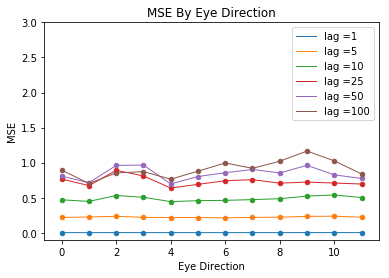

In [13]:
directions = [i for i in range(12)]
timestep_index = 0
for i in range(len(lags)):
    lag = lags[i]
    plt.plot(directions, errors_by_direction[timestep_index][i], label = "lag =" + str(lag), linewidth = 1)
    plt.scatter(directions, errors_by_direction[timestep_index][i], s =20)
    plt.xlabel("Eye Direction")
    plt.ylabel("MSE")
    plt.title("MSE By Eye Direction")
plt.ylim([-.1,3])
plt.legend()
plt.savefig("MSE_by_direction")
plt.show()

## Plot MSE by electrode channel

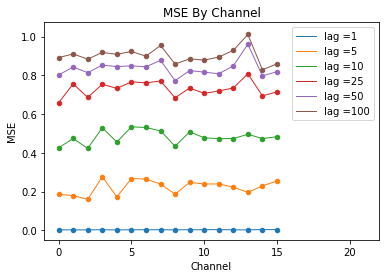

In [14]:
channels = [i for i in range(16)]
timestep_index = 0
for i in range(len(lags)):
    lag = lags[i]
    plt.plot(channels, errors_by_channel[timestep_index][i], label = "lag =" + str(lag), linewidth = 1)
    plt.scatter(channels, errors_by_channel[timestep_index][i], s = 20)
    plt.xlabel("Channel")
    plt.ylabel("MSE")
    plt.title("MSE By Channel")
plt.xlim([-1, 22])
plt.legend()
plt.savefig("MSE_by_channel")
plt.show()

## Plot MSE by time point in trial and saccade direction

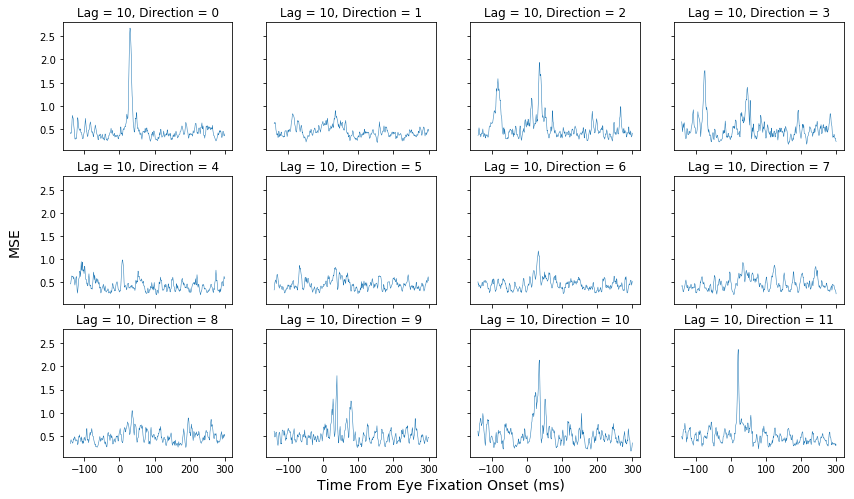

In [15]:
timestep_index = 0
lag_index = 2
lag = lags[lag_index]
timestep = timesteps[timestep_index]
sequence_length = errors_by_time[0][lag_index].shape[0]
ticks = times[600 - sequence_length:]
direcs = [i for i in range(12)]
fig, axs = plt.subplots(3,4, sharex = True, sharey = True, figsize = (14, 8))
for (direc, ax) in zip(direcs, axs.flatten()):
    ax.plot(ticks, errors_by_direction_time[(timestep,lag)][direc], linewidth = .5)
    ax.set_title("Lag = " + str(lag) + ", " + "Direction = " + str(direc))
fig.text(.5, .07, 'Time From Eye Fixation Onset (ms)', ha = 'center', fontsize = 14)
fig.text(.07, .5, 'MSE', va = 'center', rotation = 'vertical', fontsize = 14)

plt.savefig("MSE_by_time_direction_lag_" + str(lag))
plt.show()

## Plot MSE by time point in trial and electrode channel

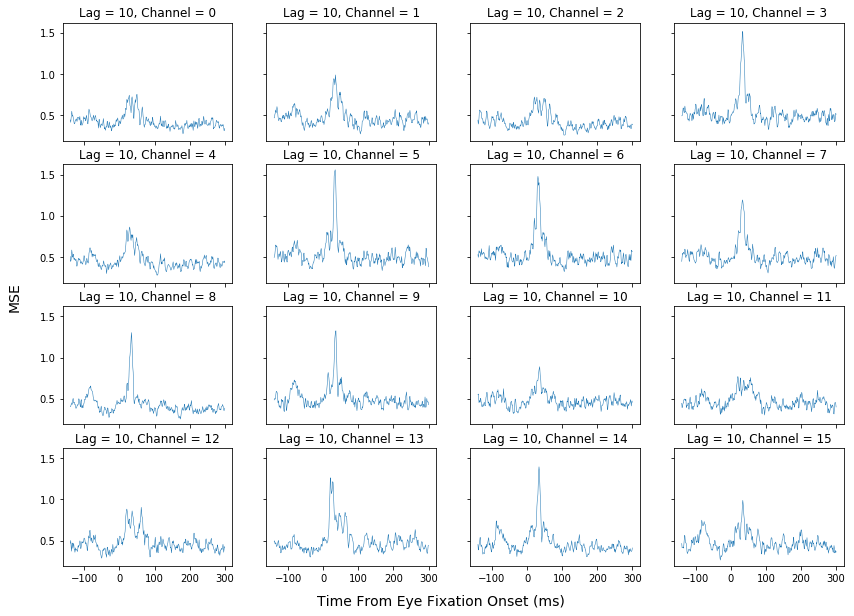

In [16]:
timestep_index = 0
lag_index = 2
lag = lags[lag_index]
timestep = timesteps[timestep_index]
sequence_length = errors_by_time[0][lag_index].shape[0]
ticks = times[600 - sequence_length:]
chls = [i for i in range(16)]
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (14, 10))
for (ch, ax) in zip(chls, axs.flatten()):
    ax.plot(ticks, errors_by_channel_time[(timestep,lag)][ch], linewidth = .5)
    ax.set_title("Lag = " + str(lags[lag_index]) + ", " + "Channel = " + str(ch))
fig.text(.5, .07, 'Time From Eye Fixation Onset (ms)', ha = 'center', fontsize = 14)
fig.text(.07, .5, 'MSE', va = 'center', rotation = 'vertical', fontsize = 14)
plt.savefig("MSE_time_channel_lag_" + str(lag))
plt.show()

## Loads a model for the purpose of visualization of a single trial - you must choose the timestep and lag

In [18]:
# indeces in timestep and lag arrays (declared in a cell above)
timestep_index = 0 
lag_index = 4
lag = lags[lag_index]
timestep = timesteps[timestep_index]
pad = False
if align_starting_timestep:
    start_index = max(timesteps) - timestep
else:
    start_index = 0

timesteps_lag_pad = str(timestep) + "_" + str(lag) + "_" + str(int(pad))
model = models.load_model('lfp_models/mdl' + timesteps_lag_pad + '.h5')
trial_sequences, trial_targets, X_train, y_train, X_test, y_test, X_val, y_val = \
create_sequences_train_test_val(trials, timestep, train_inds, test_inds, val_inds, keymapping, num_directions, 
                                encoded_eye_direc, start_index, lag, pad)

TypeError: ('Keyword argument not understood:', 'time_major')

In [96]:
y_pred = model.predict(X_test)

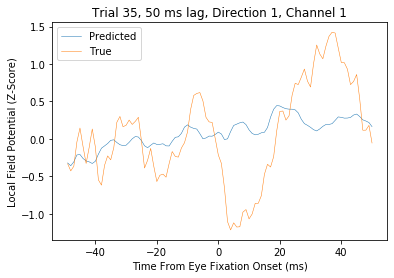

In [97]:
# choose eye direction and channel for visualization
direc = 1
channel = 1

test_inds_direc = [ind for ind in test_inds if keymapping[ind][0] == direc] # list of indeces for test trials that match 
# chosen direction

ind = 10 # chooses a particular trial from the list -- you can vary this parameter, can range from 0 to len(test_inds_direc)
# to visualize different trials

X_test_direc, y_test_direc = get_sequences_target(trial_sequences, trial_targets,[test_inds_direc[ind]],
                                                 keymapping)
y_pred_direc = model.predict(X_test_direc)

sequence_length = errors_by_time[0][lag_index].shape[0]
start = 250 - 600 + sequence_length
end = 350 - 600 + sequence_length

ticks = times[600 - sequence_length:]
trial_index = keymapping[test_inds[ind]][1]

plt.plot(ticks[start:end],y_pred_direc[start:end,channel], linewidth = .5, label = 'Predicted')
plt.plot(ticks[start:end], y_test_direc[start:end,channel], linewidth = .5, label = 'True')
plt.ylabel('Local Field Potential (Z-Score)')
plt.xlabel('Time From Eye Fixation Onset (ms)')
plt.title('Trial %d, %d ms lag, Direction %d, Channel %d' %(trial_index, lag, direc, channel))
plt.legend()
plt.savefig("trial_" + str(trial_index) + "_channel_" + str(channel) + "_direc_" + str(direc) + "_timesteps_"
            + timesteps_lag_pad)
plt.show()


# EDA

In [21]:
# choose a particular trial
trial = trials[(0, 2)]

### Visualizes a trial by channel

No handles with labels found to put in legend.


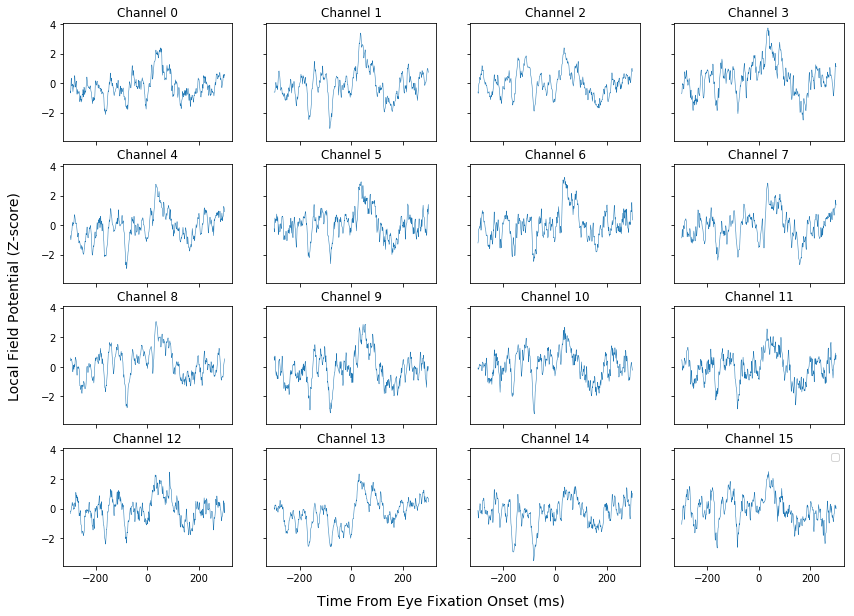

In [22]:
import seaborn as sns
sns.reset_orig()
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (14, 10))
i = 0
times = [i for i in range(-299, 301)]
for ax in axs.flatten():
    ax.plot(times, trial[:,i], linewidth = .5)
    #ax.set_xlabel('Time Until Eye Fixation')
    #ax.set_ylabel('Local Field Potential (Z-Score)')
    ax.set_title('Channel ' + str(i))
    i += 1
fig.text(0.5, 0.07, 'Time From Eye Fixation Onset (ms)', ha='center', fontsize = 14)
fig.text(0.07, 0.5, 'Local Field Potential (Z-score)', va='center', rotation='vertical', fontsize = 14)
plt.legend()
plt.savefig("trial_viz")
plt.show()

## Correlation matrix between channels

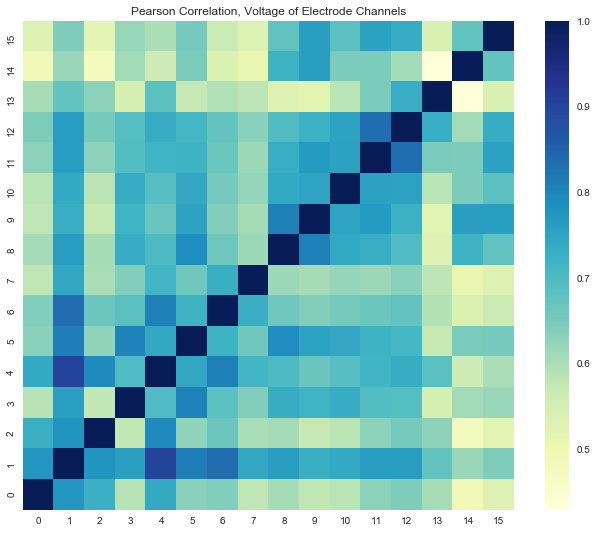

In [23]:
import seaborn as sns
sns.set()
f, ax = plt.subplots(figsize = (11, 9))
corr_matrix = data.iloc[:,:16].corr()
rename_dict = dict()
i = 0
for col in corr_matrix.columns:
    rename_dict[col] = i
    i += 1
corr_matrix = corr_matrix.rename(columns = rename_dict)
corr_matrix = corr_matrix.rename(rename_dict)
ax = sns.heatmap(corr_matrix[::-1], ax = ax, cmap="YlGnBu")
ax.set_title("Pearson Correlation, Voltage of Electrode Channels")
plt.savefig('correlation_map')
plt.show()


In [24]:
avgs = np.zeros((600, 16))
for key in trials:
    avgs += trials[key][:,:16]
avgs /= len(trials)

### Visualize Average Trial by Channel

No handles with labels found to put in legend.


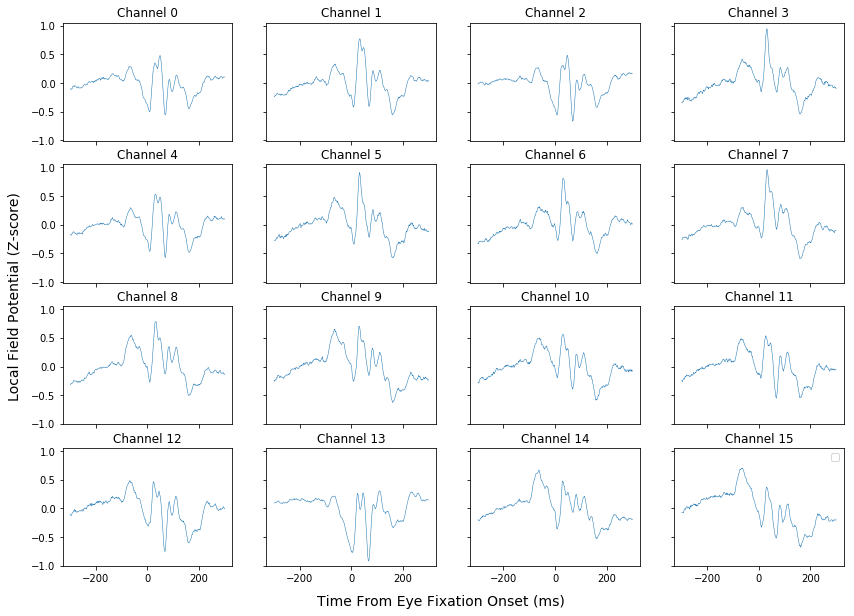

In [25]:
import seaborn as sns
sns.reset_orig()
fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (14, 10))
i = 0
times = [i for i in range(-299, 301)]
for ax in axs.flatten():
    ax.plot(times, avgs[:,i], linewidth = .5)
    #ax.set_xlabel('Time Until Eye Fixation')
    #ax.set_ylabel('Local Field Potential (Z-Score)')
    ax.set_title('Channel ' + str(i))
    i += 1
fig.text(0.5, 0.07, 'Time From Eye Fixation Onset (ms)', ha='center', fontsize = 14)
fig.text(0.07, 0.5, 'Local Field Potential (Z-score)', va='center', rotation='vertical', fontsize = 14)
plt.legend()
plt.savefig("avg_viz")
plt.show()

In [26]:
# can change channel variable below for different visualizations
trials_by_direc = np.zeros((600, 12))
num_per_direc = np.zeros(12)
channel = 0 # choose channel
for key in trials:
    direc = key[0]
    trials_by_direc[:, direc] += trials[key][:,channel]
    num_per_direc[direc] += 1
trials_by_direc /= num_per_direc

## Visualizes average trial, for a chosen channel, by direction

No handles with labels found to put in legend.


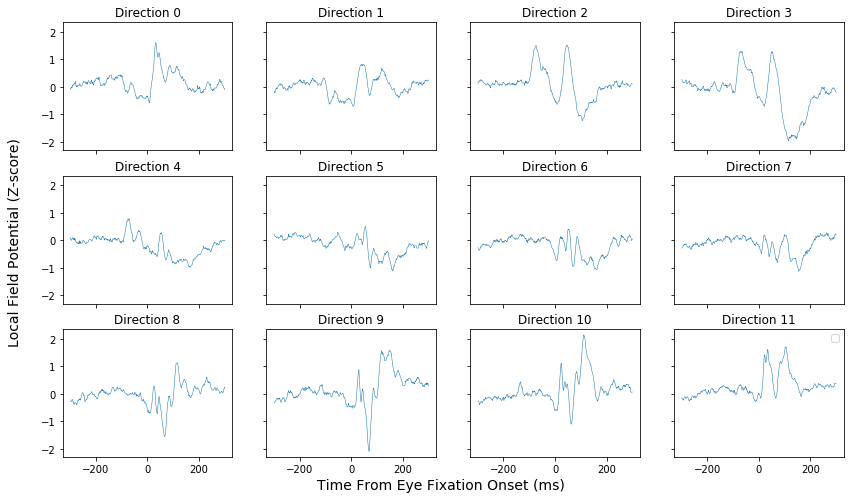

In [27]:
import seaborn as sns
sns.reset_orig()
fig, axs = plt.subplots(3,4, sharex = True, sharey = True, figsize = (14, 8))
i = 0
times = [i for i in range(-299, 301)]
for ax in axs.flatten():
    ax.plot(times, trials_by_direc[:,i], linewidth = .5)
    #ax.set_xlabel('Time Until Eye Fixation')
    #ax.set_ylabel('Local Field Potential (Z-Score)')
    ax.set_title('Direction ' + str(i))
    i += 1
fig.text(0.5, 0.07, 'Time From Eye Fixation Onset (ms)', ha='center', fontsize = 14)
fig.text(0.07, 0.5, 'Local Field Potential (Z-score)', va='center', rotation='vertical', fontsize = 14)
plt.legend()
plt.savefig("direc_viz")
plt.show()